In [1]:
import os
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy

from scipy import signal
from scipy import stats

# MNE & associated code
import mne
from mne.preprocessing import ICA, create_eog_epochs

# FOOOF, and custom helper & utility functions
from fooof import FOOOF, FOOOFGroup
from fooof.objs import average_fg
from fooof.plts import plot_spectrum
from fooof.utils import trim_spectrum
from fooof.analysis import get_band_peak_fm, get_band_peak_fg
from fooof.plts.spectra import plot_spectra
from fooof.plts.style import style_spectrum_plot



import pandas as pd
from openpyxl import load_workbook

In [2]:
''' need:
index - choosing index of the tested person
folder - from where upload data
excel_file - used to save the results '''

data_file = os.path.join(folder, index, 'fmrs_' + index + '_sent.vhdr')
events_file = os.path.join('events' + index + '_eve.fif')

In [3]:
SAVE_FIG = False

# Sentences and correct answers


In [4]:
eeg_data = mne.io.read_raw_brainvision(data_file, preload = True)
events, events_id = mne.events_from_annotations(eeg_data)
eventsloaded = mne.write_events(events_file, events)
Fs = eeg_data.info['sfreq']

Extracting parameters from E:/LICENCJAT/dane_eeg/badanie\001\fmrs_001_sent.vhdr...
Setting channel info structure...
Reading 0 ... 711469  =      0.000 ...  1422.938 secs...
Used Annotations descriptions: ['New Segment/', 'Response/R  1', 'Response/R  2', 'Response/R  3', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S  7', 'Stimulus/S  8', 'Stimulus/S  9', 'Stimulus/S 11', 'Stimulus/S 12']


In [5]:
#false
S6 = mne.read_events(events_file, include = [6]) #start
S8 = mne.read_events(events_file, include = [8]) #end
R2 = mne.read_events(events_file, include = [1002]) #response

#true
S7 = mne.read_events(events_file, include = [7])
S9 = mne.read_events(events_file, include = [9])
R1 = mne.read_events(events_file, include = [1001])

In [6]:
# setting reference
eeg_data.set_eeg_reference(ref_channels= ['A1', 'A2'])
eeg_data.drop_channels(['A1', 'A2'])

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


<RawBrainVision | fmrs_001_sent.eeg, 62 x 711470 (1422.9 s), ~336.6 MB, data loaded>

In [7]:
# data filtering
eeg_data = eeg_data.filter(0.1, 45, picks=None, filter_length='auto', l_trans_bandwidth='auto', h_trans_bandwidth='auto', n_jobs=1, method='iir', iir_params=None, phase='zero', fir_window='hamming', fir_design='firwin', skip_by_annotation=('edge', 'bad_acq_skip'), pad='reflect_limited', verbose=None)
eeg_data = eeg_data.notch_filter(freqs = 50, picks=None, filter_length='auto', notch_widths=None, trans_bandwidth=1.0, n_jobs=1, method='iir', iir_params=None, mt_bandwidth=None, p_value=0.05, phase='zero', fir_window='hamming', fir_design='firwin', pad='reflect_limited', verbose=None)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 45 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 45.00 Hz: -6.02, -6.02 dB

Setting up band-stop filter from 49 - 51 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 49.38, 50.62 Hz: -6.02, -6.02 dB



In [8]:
def closest(l, Number):
  '''finding the closest marker to the given time index'''
  temp = []
  for i in l:
      temp.append(abs(Number-i))
  return temp.index(min(temp))


def comparing_min(n1, n2, mynumber):
  '''used to compare closest response marker with the end marker'''

  if abs(n1 - mynumber) > abs(n2 - mynumber):
    return n2
  return n1

In [9]:
def CorrectMarkers(start, end):
  '''used to check if the number of starts and ends in given data is the same;
    if not - deleting the single ones'''

  while len(start) != len(end):
    if len(start) > len(end):
      for i in range(len(start)):
        if abs(start[i] - end[i]) > 2.8 * Fs:
          start.pop(i)
          break

    else:
      for i in range(len(end)):
        if abs(end[i] - start[i]) > 2.8 * Fs:
          end.pop(i)
          break
    if len(start) == len(end):
      break

  return start, end

def AnswersPreprocessing(log_value: str): #true if true sentences; false if false
  'saving starts and ends of sentenceswith the correct answers within 1s after the ending'
  start = []
  end = []

  if log_value == 'true':
    start_markers = list(S7[:,0])
    end_markers = list(S9[:,0])
  elif log_value == 'false':
    start_markers = list(S6[:,0])
    end_markers = list(S8[:,0])

  ans_true = list(R1[:,0])
  ans_false = list(R2[:,0])

  if len(start_markers) != len(end_markers):
   start_markers, end_markers = CorrectMarkers(start_markers, end_markers)

  for i in range(len(end_markers)):
    marker = end_markers[i]
    min_true = ans_true[closest(ans_true, marker)]
    min_false = ans_false[closest(ans_false, marker)]
    if (log_value == 'true' and (min_true - marker) <= Fs and (min_true - marker) >= 0 ) or (log_value == 'false' and (min_false - marker) <= Fs and (min_false - marker) >= 0):
      start.append(start_markers[i])
      end.append(end_markers[i])

  return start, end

In [10]:
true_start, true_end = AnswersPreprocessing('true')
false_start, false_end = AnswersPreprocessing('false')
starts = sorted(true_start + false_start)
ends = sorted(true_end + false_end)

ALL = []

''' data cutting and windowing'''
for i in range(len(starts)):
    eeg_copy = eeg_data.copy()
    crop_data = eeg_copy.crop(tmin = starts[i]/Fs, tmax=(ends[i]/Fs), include_tmax=False)
    data_copy = eeg_data.get_data()
    fr_data = data_copy[:,int(starts[i]):int(ends[i])]
    tukey = np.zeros((fr_data.shape[0], fr_data.shape[1]))
    for j in range(fr_data.shape[0]):
      tukey[j,:] = signal.windows.tukey(fr_data.shape[1], alpha = 0.01)*fr_data[j,:]
    crop_data._data = tukey
    ALL.append(crop_data)

'''creating continuous data'''
ALL_DATA = ALL[0]
ALL_DATA.append(ALL[1:])
correct_data_file = os.path.join('fmrs_' + index + '_all_sent.raw.fif')
ALL_DATA.save(correct_data_file, overwrite = True)

Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
Writing e:\LICENCJAT\bez_miesni\fmrs_001_all_sent.raw.fif
Closing e:\LICENCJAT\bez_miesni\fmrs_001_all_sent.raw.fif
[done]


# Preprocessing

In [11]:
eeg = mne.io.read_raw_fif(correct_data_file, preload = True)
chans = eeg.ch_names

Opening raw data file fmrs_001_all_sent.raw.fif...
Isotrak not found
    Range : 221053 ... 433249 =    442.106 ...   866.498 secs
Ready.
Reading 0 ... 212196  =      0.000 ...   424.392 secs...


In [12]:
chs = mne.channels.make_standard_montage('standard_1020')
eeg.set_montage(chs, verbose=False)

<Raw | fmrs_001_all_sent.raw.fif, 62 x 212197 (424.4 s), ~100.5 MB, data loaded>

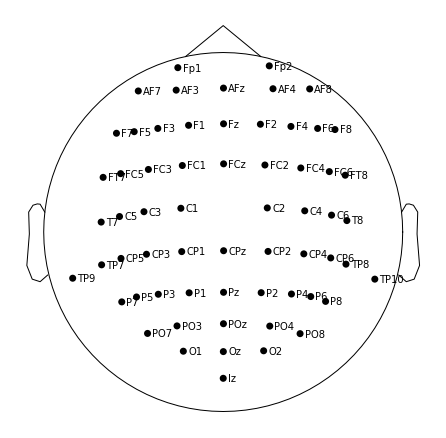

In [13]:
eeg.plot_sensors(kind = 'topomap', show_names=True)
plt.show()

Effective window size : 4.096 (s)


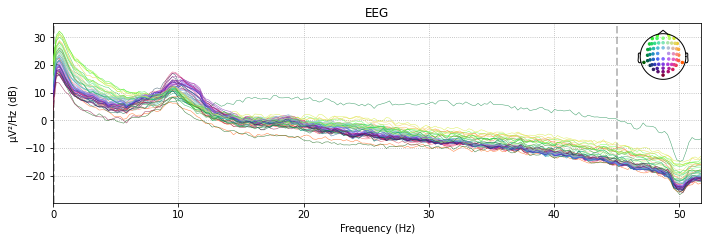

In [15]:
eeg.plot_psd(fmin = 0, fmax = 52)
plt.show()

In [16]:
def RejectingChannels(data):
  '''detecting channels with poor quality signal'''
  moments4 = np.zeros(len(chans))
  for i in range(data.shape[0]):
    moments4[i] = scipy.stats.moment(data[i,:], moment = 4)
  zscore = scipy.stats.zscore(moments4)
  ind = []
  for i in range(len(moments4)):
    if zscore[i] > 5:
      ind.append(chans[i])
  return ind

In [17]:
bads_data = eeg.get_data()
bads = RejectingChannels(bads_data)
eyes_electrodes = ['Fp1', 'Fp2']
for element in eyes_electrodes:
  if element in bads:
    bads.remove(element)

eeg.info['bads'] = bads

bads_array = np.zeros(len(chans))
for ch in bads:
    inx  = chans.index(ch)
    bads_array[inx] = 'bad' 
    

In [18]:
eeg = eeg.interpolate_bads()

C:\Users\jurko\AppData\Local\Temp/ipykernel_5676/2705496506.py:1: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  eeg = eeg.interpolate_bads()


Using EOG channels: Fp1, Fp2
EOG channel index for this subject is: [0 1]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 165 significant peaks
Number of EOG events detected: 165
Not setting metadata
Not setting metadata
165 matching events found
No baseline correction applied
Loading data for 165 events and 501 original time points ...
111 bad epochs dropped
Applying baseline correction (mode: mean)
No projector s

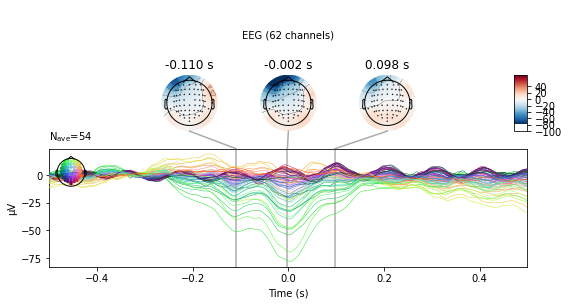

In [19]:
eeg_copy = eeg.copy()
eog_evoked = create_eog_epochs(eeg_copy, ch_name = eyes_electrodes).average()
eog_evoked.apply_baseline(baseline=(None, -0.2))
eog_evoked.plot_joint()
plt.show()

Fitting ICA to data using 62 channels (please be patient, this may take a while)
Selecting by explained variance: 48 components
Fitting ICA took 37.4s.


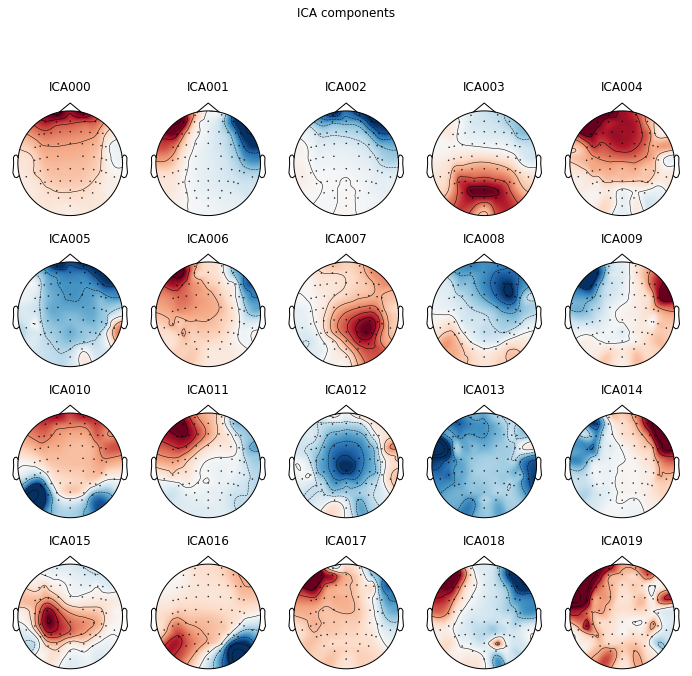

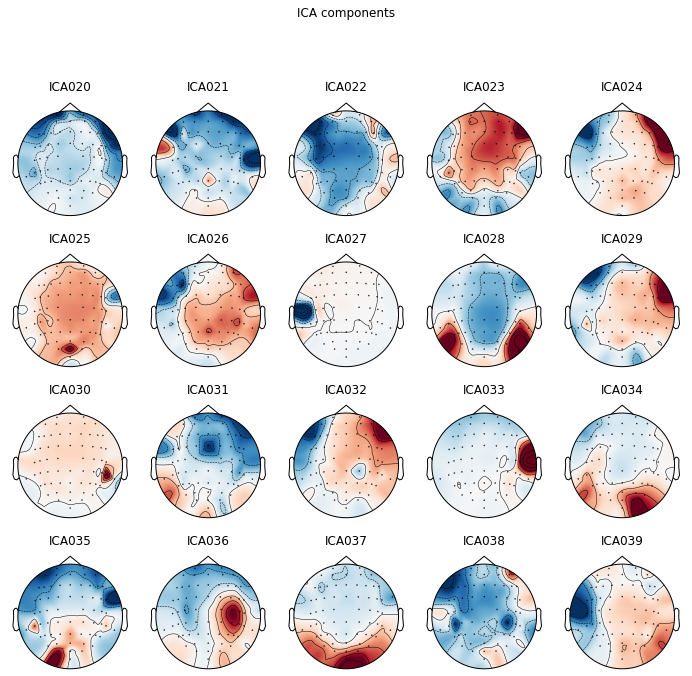

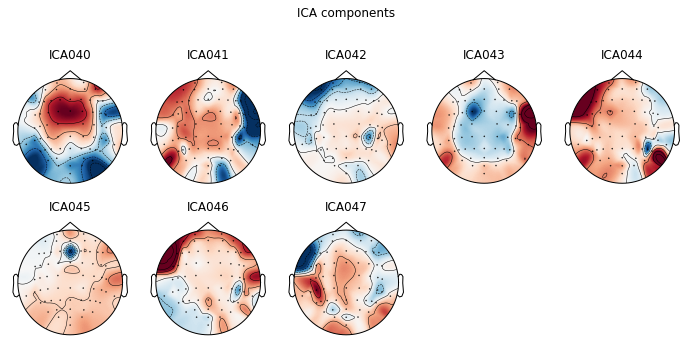

In [20]:
method = 'fastica'

# n_components = 0.99   zmieniam
decim = None
reject = {'eeg': 10e-4}

# Initialize ICA object
ica = ICA(n_components= 0.999, method=method)

# Fit ICA
ica.fit(eeg, decim=decim, reject=reject)

ica.plot_components()
ica_comp = ica.get_sources(eeg)

In [21]:
n_comp = ica.n_components_
ica_comp_data = ica_comp.get_data()

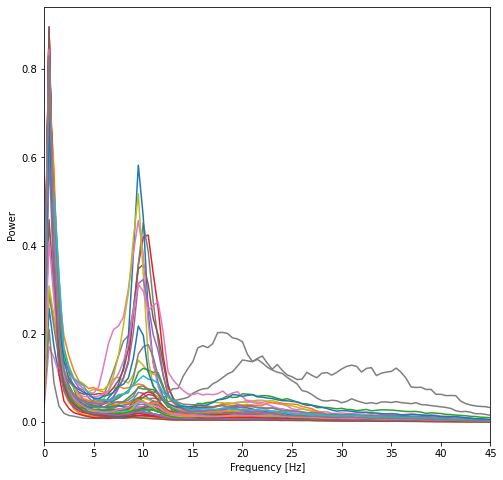

In [24]:
f, P = scipy.signal.welch(ica_comp_data, fs=Fs, window='hann', nperseg=2*Fs, noverlap=Fs, nfft=2*Fs, 
                          detrend='constant', return_onesided=True, scaling='density', axis= 1, average='mean')

'''algorithm for the detection of muscle components'''
f_max = np.where((f>20)&(f<45))[0]
f_min = np.where((f>1)&(f<15))[0]
all_norm = []
plt.figure(figsize = (8,8))
for i in range(n_comp):
    P_norm = P[i, :]/np.linalg.norm(P[i, :])
    plt.plot(f, P_norm)
    plt.xlim((0, 45))
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Power')
    norm = np.sum(P[i, f_max])/np.sum(P[i, f_min])
   # print(f'{i} - {norm}')
    all_norm.append(norm)
plt.show()

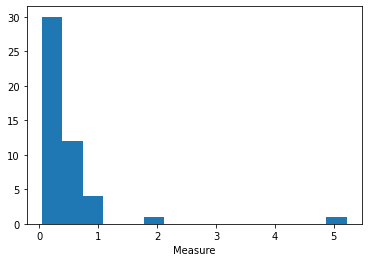

In [25]:
plt.figure()
plt.hist(np.array(all_norm), bins = 15)
plt.xlabel('Measure')
plt.show()

In [27]:
all_norm = np.array(all_norm)
q1 = stats.scoreatpercentile(np.ravel(all_norm), 25)
q3 = stats.scoreatpercentile(np.ravel(all_norm), 75)
iqr = q3 - q1
c1 = q1 - 1.5*iqr
c2 = q3 + 1.5*iqr

logical = np.logical_or(all_norm < c1, all_norm > c2)
#print(logical)
print(f'Components with muscle artifacts {np.where(logical == True)[0]}') 
muscle_exclude = list(np.where(logical == True)[0])

Components with muscle artifacts [17 22 27]


In [28]:
eeg_ica1 = ica.apply(eeg_copy, exclude = muscle_exclude) #excluding muscle artifacts

Applying ICA to Raw instance
    Transforming to ICA space (48 components)
    Zeroing out 3 ICA components
    Projecting back using 62 PCA components


In [29]:
method = 'fastica'

# n_components = 0.99   zmieniam
decim = None
reject = {'eeg': 10e-4}

# Initialize ICA object
ica2 = ICA(n_components= 0.999, method=method)

# Fit ICA
ica2.fit(eeg_ica1, decim=decim, reject=reject)

Fitting ICA to data using 62 channels (please be patient, this may take a while)
Selecting by explained variance: 45 components
Fitting ICA took 15.6s.


Method,fastica
Fit,59 iterations on raw data (212000 samples)
ICA components,45
Explained variance,99.9 %
Available PCA components,62
Channel types,eeg
ICA components marked for exclusion,—


Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.2

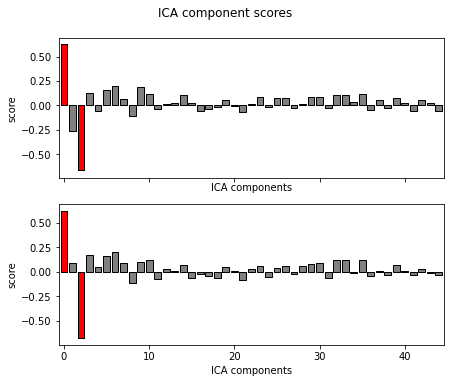

Creating RawArray with float64 data, n_channels=62, n_times=212000
    Range : 0 ... 211999 =      0.000 ...   423.998 secs
Ready.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
212 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
212 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


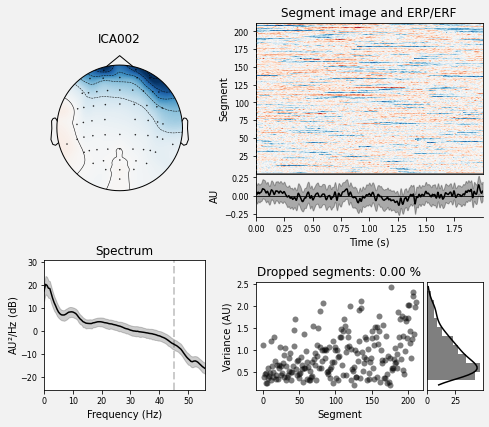

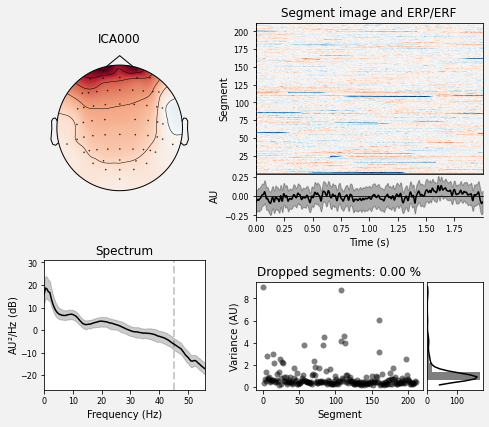

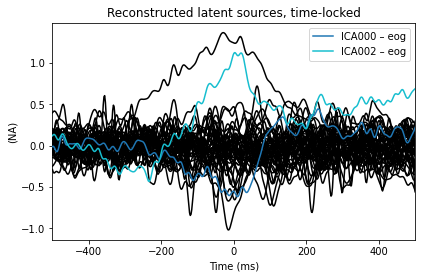

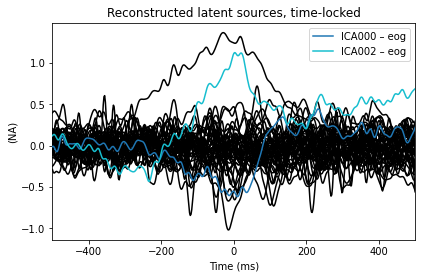

In [31]:
ica2.exclude = []
# find which ICs match the EOG pattern
eog_indices, eog_scores = ica2.find_bads_eog(eeg_ica1.copy(), ch_name = eyes_electrodes)
ica2.exclude = eog_indices

# barplot of ICA component "EOG match" scores
ica2.plot_scores(eog_scores)

# plot diagnostics
ica2.plot_properties(eeg_ica1.copy(), picks=eog_indices)

# plot ICs applied to raw data, with EOG matches highlighted
#ica2.plot_sources(eeg_ica1.copy(), show_scrollbars=False)

# plot ICs applied to the averaged EOG epochs, with EOG matches highlighted
ica2.plot_sources(eog_evoked)

In [32]:
print(f'Components containing eye artifacts {eog_indices}')

Components containing eye artifacts [2, 0]


Applying ICA to Raw instance
    Transforming to ICA space (45 components)
    Zeroing out 2 ICA components
    Projecting back using 62 PCA components


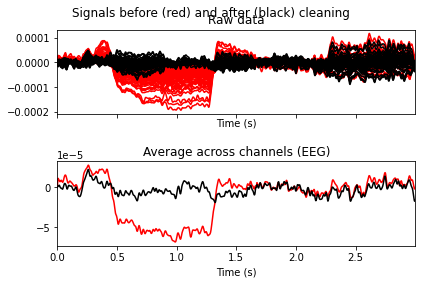

In [33]:
ica2.plot_overlay(eeg_ica1, exclude = eog_indices)
plt.show()

In [34]:
eeg_ica = ica2.apply(eeg_ica1.copy(), exclude = eog_indices) #excluding eye artifacts

Applying ICA to Raw instance
    Transforming to ICA space (45 components)
    Zeroing out 2 ICA components
    Projecting back using 62 PCA components


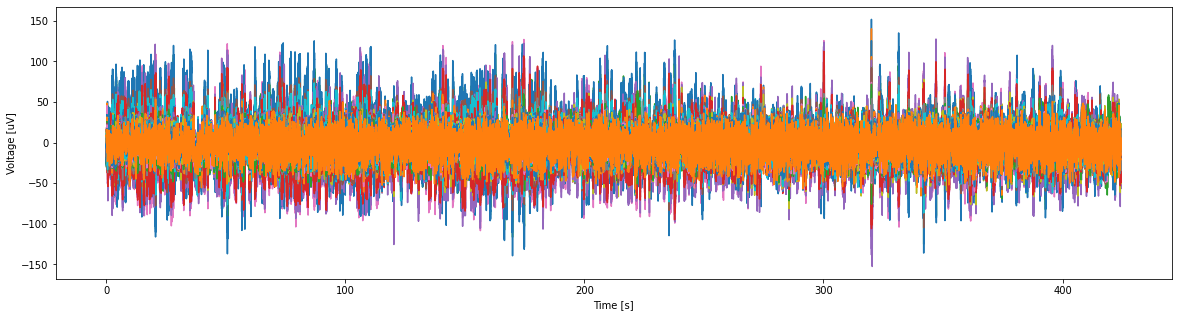

In [39]:
data_post_ica = eeg_ica.get_data(units = 'uV')
time = np.arange(0, data_post_ica.shape[1]/Fs, 1/Fs)
fig = plt.figure(figsize = (20, 5))
for i in range(data_post_ica.shape[0]):
  plt.plot(time, data_post_ica[i, :])
plt.xlabel('Time [s]')
plt.ylabel('Voltage [uV]')
plt.show()

In [40]:
events = mne.make_fixed_length_events(eeg_ica, id=1, start=0, stop=None, duration=2.0, first_samp=False, overlap=0.0)

In [41]:
def RejectingSignals(data, events):
  '''choosing two-second fragments of data to reject based on outlier amplitude'''
  moments = np.zeros((data.shape[0], events.shape[0]))
  for i in range(1, events.shape[0]):
    s = data[:, int(events.T[0][i-1]/Fs):int(events.T[0][i]/Fs)]

    for ch in range(data.shape[0]):
      moments[ch, i] = scipy.stats.moment(s[ch, :], moment = 2)

  q1 = stats.scoreatpercentile(np.ravel(moments), 25)
  q3 = stats.scoreatpercentile(np.ravel(moments), 75)
  iqr = q3 - q1
  c1 = q1 - 1.5*iqr
  c2 = q3 + 1.5*iqr

  logical = np.logical_or(moments < c1, moments > c2)
  log_sum = np.sum(logical, axis = 0)
  fragments = log_sum == 0
  return fragments


In [42]:
bad_events = RejectingSignals(data_post_ica, events)
idx = list(np.nonzero(bad_events)[0])

In [43]:
good_events = np.delete(events, idx, 0)

# Power Analysis

In [44]:
raw_power = []

for i in range(good_events.shape[0]):
    eeg_copy = eeg_ica.copy()
    crop_data = eeg_copy.crop(tmin = (good_events[i][0]/500), tmax=(good_events[i][0]/500) + 2, include_tmax=True)
    raw_power.append(crop_data)

In [45]:
n_fft, n_overlap, n_per_seg = int(2*Fs), int(Fs), int(2*Fs)

# Data settings
fmin, fmax = (0.1, 40)
tmin, tmax = (0, 2)

PSDS = np.zeros((len(eeg_ica.ch_names), 2*fmax, len(raw_power)))
for i in range(len(raw_power)):
  psds, freqs = mne.time_frequency.psd_welch(raw_power[i], fmin=fmin, fmax=fmax, tmin=tmin, tmax=tmax, n_fft=n_fft, n_overlap=n_overlap, 
                             n_per_seg=n_per_seg, picks=None, proj=False, n_jobs=1, reject_by_annotation=True, average='mean', window='hamming', verbose=False)
  PSDS[:, :, i] = psds

PSDS = np.mean(PSDS, axis = 2)

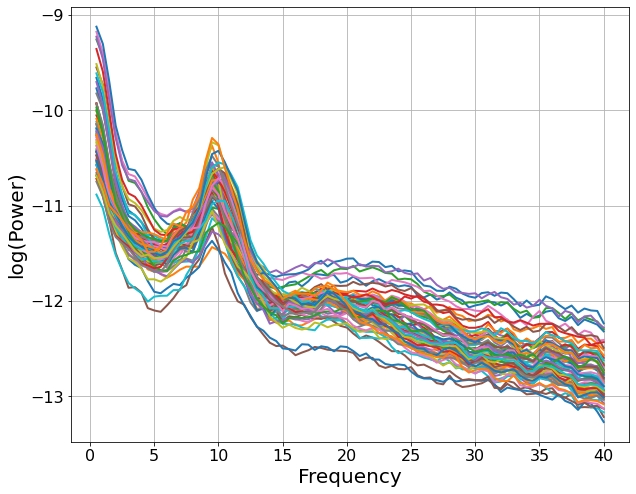

In [46]:
plot_spectra(freqs, PSDS, log_freqs=False, log_powers=True, labels=None,
                 ax=None, plot_style=style_spectrum_plot)

# FOOOF

A progress bar requiring the 'tqdm' module was requested, but 'tqdm' is not installed. 
Proceeding without using a progress bar.
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 1 - 40 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -10.6117, 1.3223                                         
                                                                               

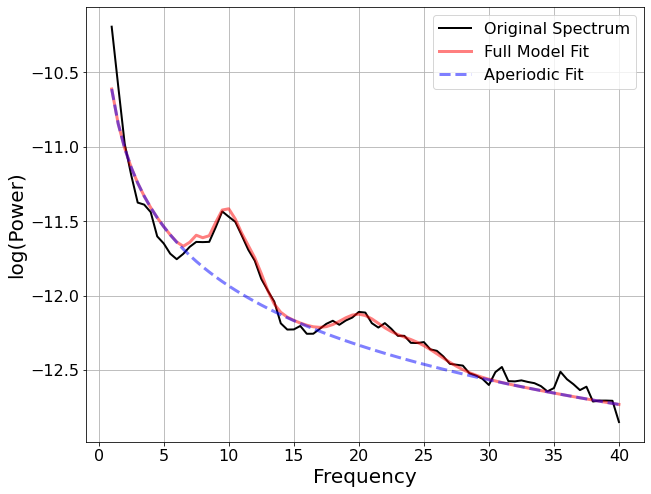

In [47]:
f_range = [1, 40]
fg = FOOOFGroup(peak_width_limits=[1, 8], max_n_peaks=6,
                min_peak_height=0.1)

# Run FOOOF across all power spectra
fg.fit(freqs, PSDS, f_range, progress='tqdm.notebook')

# Check FOOOF model fit of particular channel of interest
ch_ind = chans.index('T7')
fm = fg.get_fooof(ch_ind, True)
fm.print_results()
fm.plot()



In [48]:
al_freqs, al_psd = trim_spectrum(freqs, PSDS[ch_ind,:], [7, 14])
icf_ind = np.argmax(al_psd)
al_icf = al_freqs[icf_ind]

In [49]:
# Extract individualized CF from channel T7
fooof_freq, _, fooof_bw = get_band_peak_fm(fm, [7,14])

# If not FOOOF alpha extracted, reset to 10
if np.isnan(fooof_freq):
    fooof_freq = 10

# Compare peak-find alpha peak to fooof alpha peak
print('IndiPeak CF: \t{:0.2f}'.format(al_icf))
print('FOOOF    CF: \t{:0.2f}'.format(fooof_freq))

IndiPeak CF: 	9.50
FOOOF    CF: 	9.86


In [50]:
# Check extracted FOOOF alpha properties
print('Alpha CF: \t{:0.2f}'.format(fooof_freq))
print('Alpha BW: \t{:0.2f}'.format(fooof_bw))

Alpha CF: 	9.86
Alpha BW: 	2.13


C:\Users\jurko\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\fooof\objs\group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


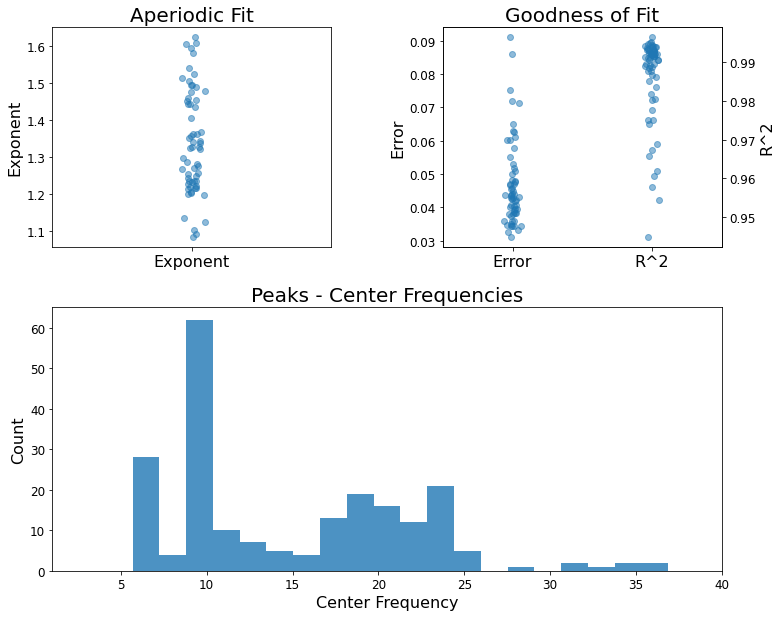

In [51]:
# Check a summary of the FOOOFGroup results across all channels
fg.plot()

In [52]:
# Extract some FOOOF data across all electrodes

# Extract exponents - all channels
all_exps = fg.get_params('aperiodic_params', 'exponent')

# Extract offsets - all channels
all_offsets = fg.get_params('aperiodic_params', 'offset')

# Extract alpha oscillations - all channels
alphas = get_band_peak_fg(fg, [7,14])

r2 = fg.get_params('r_squared')
error = fg.get_params('error')

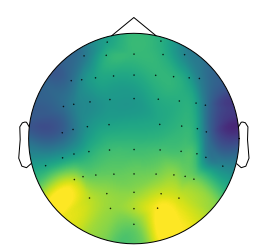

In [53]:
# Plot alpha topography
data_ind = 1 # 0:CF; 1:PW; 2:BW

# For sake of visualization, replace any NaN with the mean
temp_data = alphas[:, data_ind]
inds = np.where(np.isnan(temp_data))
temp_data[inds] = np.nanmean(temp_data)

mne.viz.plot_topomap(temp_data, eeg_ica.info, cmap=cm.viridis, contours=0);

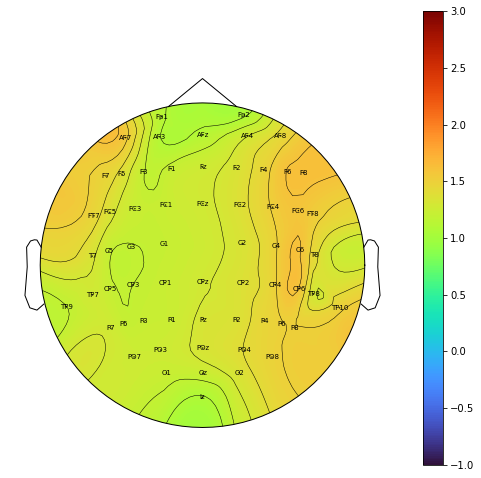

In [54]:
# Plot exponent topography
fig,ax = plt.subplots(figsize = (7,7))
im, cm = mne.viz.plot_topomap(all_exps, eeg_ica.info, vmin = -1, vmax = 3, cmap = 'turbo', show = False, names = eeg_ica.ch_names, show_names=True)
ax_x_start = 0.95
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.9
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax, ticks = None)
# plt.savefig('E:/LICENCJAT/topomaps/' + index)

In [55]:
results = {'Channel names' : eeg_ica.ch_names, 'Exponent': list(all_exps), 'Offset' : list(all_offsets), 
               'Alpha Peak' : list(alphas[:, 0]), 'Alpha Power': list(alphas[:, 1]), 'Alpha Bandwith' : list(alphas[:, 2]), 'Bad Channels': bads_array, 'R^2':list(r2), 'Error': list(error)}

In [56]:
df_results = pd.DataFrame.from_dict(results)

In [57]:
book = load_workbook(excel_file)

writer = pd.ExcelWriter(excel_file, engine = 'openpyxl')
writer.book = book

df_results.to_excel(writer, sheet_name = str(index), index = False)
writer.save()
writer.close()